In [1]:
cd /home

/home


# Results experiments

###### by Cristobal Donoso-Oliva et.al., 2022

In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import pandas as pd
import numpy as np
import tomli
import os 

from src.pipeline.base import load_pt_data, compile_astromer
from src.models        import get_ASTROMER_2, get_ASTROMER
from src.utils import get_metrics

%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

# plt.style.use('dark_background')|

## Pretraining results

First we take an arbitrary config file from the `experiments_config_files` folder

In [221]:
mean_rmse = []
mean_rsquare = []
x_labels = []
for exp in ['ns_1', 'ns_2', 1, 2]:
    for base in [1e3, 1e4]:
        print('-'*100)
        try:                
            experiments_config_files = f'./presentation/experiments/astromer_2/config_files/macho_{exp}_{int(base)}/'
            with open(os.path.join(experiments_config_files, os.listdir(experiments_config_files)[0]), mode="rb") as fp:
                config = tomli.load(fp)

            metrics = pd.read_csv(os.path.join(config['pretraining']['exp_path'], 'metrics.csv'))

            loss = metrics['rmse'].values[0]
            r2 = metrics['r_square'].values[0]
            
            if type(exp) == int:
                x_labels.append(r'$\alpha$='+str(exp)+'\n base='+str(base))
            else:
                x_labels.append(r'ns $\alpha$='+str(exp.split('_')[-1])+'\n base='+str(base))
                
            mean_rmse.append(loss)
            mean_rsquare.append(r2)
        except:
            continue

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Text(0.5, -0.5, 'Exponent $\\alpha$ from $base^{(\\alpha j/D_{pe})}$ the positional encoder')

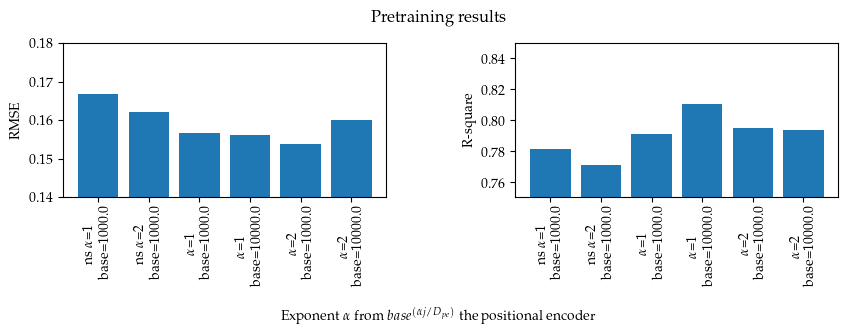

In [225]:
fig, axes = plt.subplots(1, 2, sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.4}, figsize=(10, 2))

x_range = np.arange(0, len(mean_rmse))
axes[0].bar(x_range, mean_rmse)
axes[0].set_xticks(x_range, x_labels, rotation=90)
axes[0].set_ylim(0.14, 0.18)

axes[1].bar(x_range, mean_rsquare)
axes[1].set_xticks(x_range, x_labels, rotation=90)

axes[1].set_ylim(0.75, 0.85)

axes[0].set_ylabel('RMSE')
axes[1].set_ylabel('R-square')

fig.suptitle('Pretraining results', x=0.5, y=1.05)
fig.text(0.5, -0.5, r'Exponent $\alpha$ from $base^{(\alpha j/D_{pe})}$ the positional encoder', ha='center')

In [7]:
'./presentation/experiments/astromer_2/config_files/macho/'

'./presentation/experiments/astromer_2/config_files/macho/'

In [60]:
import itertools

[INFO] Using learning rate: 1e-05
(1, 256)
[INFO] Using learning rate: 1e-05
(1, 256)
[INFO] Using custom scheduler
(1, 256)
[INFO] Using custom scheduler
(1, 256)
[INFO] Using custom scheduler
(1, 256)
[INFO] Using custom scheduler
(1, 256)


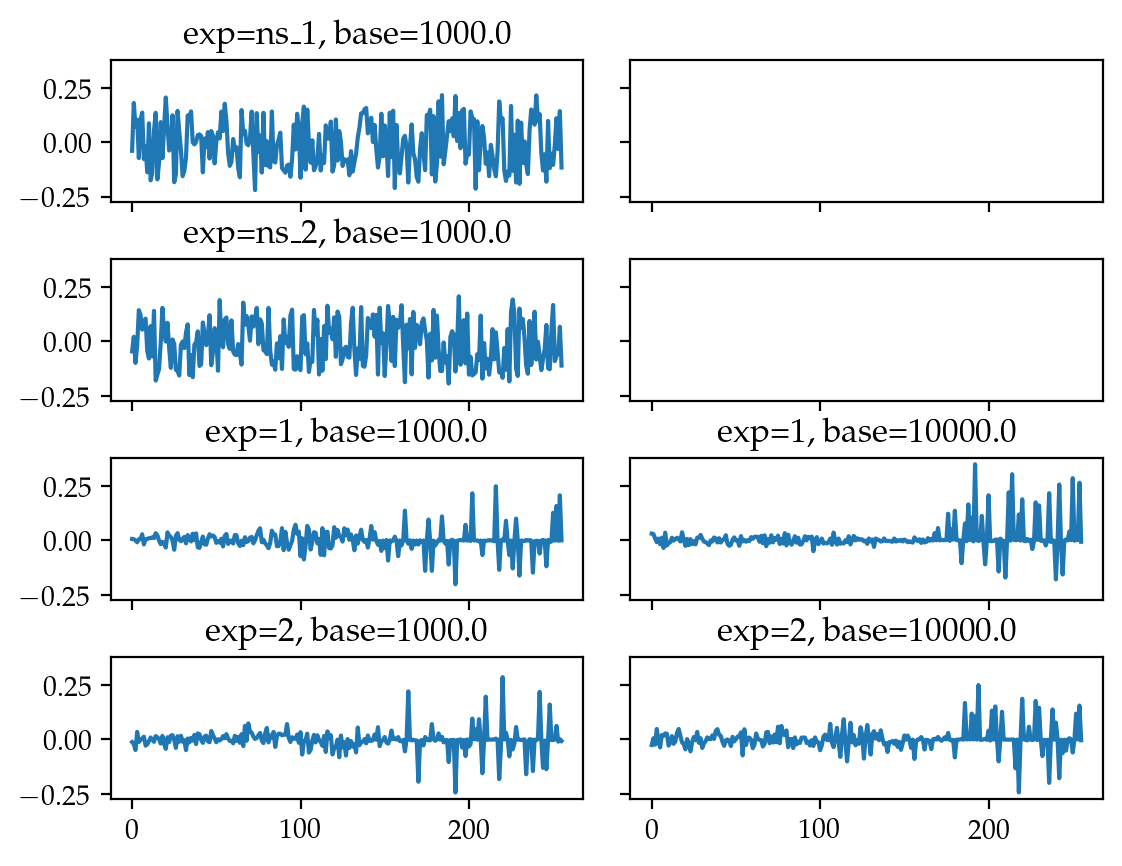

In [61]:
fig, axes = plt.subplots(4, 2, gridspec_kw={'hspace': 0.4, 'wspace': 0.1},
                         sharey=True, sharex=True, dpi=200)
iterables = itertools.product(*[['ns_{}'.format(1), 'ns_{}'.format(2), 1, 2], [1e3, 1e4]])
for tuplex, ax in zip(iterables, axes.flatten()):
    try:
        experiments_config_files = f'./presentation/experiments/astromer_2/config_files/macho_{tuplex[0]}_{int(tuplex[1])}'
        with open(os.path.join(experiments_config_files, os.listdir(experiments_config_files)[0]), mode="rb") as fp:
            config = tomli.load(fp)

        d_model = config['astromer']['head_dim']*config['astromer']['heads']
        astromer =  get_ASTROMER_2(num_layers=config['astromer']['layers'],
                                   d_model=d_model,
                                   num_heads=config['astromer']['heads'],
                                   dff=config['astromer']['dff'],
                                   base=config['positional']['base'],
                                   dropout=config['astromer']['dropout'],
                                   maxlen=config['astromer']['window_size'],
                                   pe_c=base)

        astromer = compile_astromer(config, astromer, step='pretraining')
        astromer.load_weights(os.path.join(config['finetuning']['weights'], 'weights')).expect_partial()
        encoder = astromer.get_layer('encoder')

        W = encoder.inp_transform.weights[0]
        print(W.shape)
        b = encoder.inp_transform.weights[1]
        ax.set_title('exp={}, base={}'.format(tuplex[0],tuplex[1]))
        ax.plot(W[0])
    except:
        continue

In [199]:
iterables = itertools.product(*[['ns_{}'.format(1), 'ns_{}'.format(2), 1, 2], [1e3, 1e4]])
results_values = []
results_labels = []
for tuplex, ax in zip(iterables, axes.flatten()):
    try:
        experiments_config_files = f'./presentation/experiments/astromer_2/config_files/macho_{tuplex[0]}_{int(tuplex[1])}'
        with open(os.path.join(experiments_config_files, os.listdir(experiments_config_files)[0]), mode="rb") as fp:
            config = tomli.load(fp)
            
            path = '/'.join(config['classification']['exp_path'].split('/')[:-2])
            metrics = pd.read_csv(path+'/metrics.csv')
            
            partial_values = []
            partial_labels = []
            for spc, frame in metrics.groupby('spc'):
                mean_f1 = frame['test_f1'].mean()
                std_f1 = frame['test_f1'].std()
                partial_values.append((mean_f1, std_f1))
                partial_labels.append(spc)
                
        results_values.append(partial_values)
        
        
        if not type(tuplex[0]) == int:
            label = r'$\alpha$={} w/o scheduler'.format(tuplex[0].split('_')[-1]) 
        else:
            label = r'$\alpha$={}'.format(tuplex[0])
        label = '{} base={}'.format(label, int(tuplex[-1]))            
        results_labels.append(label)
    except Exception as e:
        print(e)
        continue

[Errno 2] No such file or directory: './presentation/experiments/astromer_2/config_files/macho_ns_1_10000'
[Errno 2] No such file or directory: './presentation/experiments/astromer_2/config_files/macho_ns_2_10000'
[Errno 2] No such file or directory: './presentation/experiments/astromer_2/results/macho_1_10000/alcock/classification/metrics.csv'


In [200]:
results_labels

['$\\alpha$=1 w/o scheduler base=1000',
 '$\\alpha$=2 w/o scheduler base=1000',
 '$\\alpha$=1 base=1000',
 '$\\alpha$=2 base=1000',
 '$\\alpha$=2 base=10000']

Text(0.5, 0, 'Samples per Class')

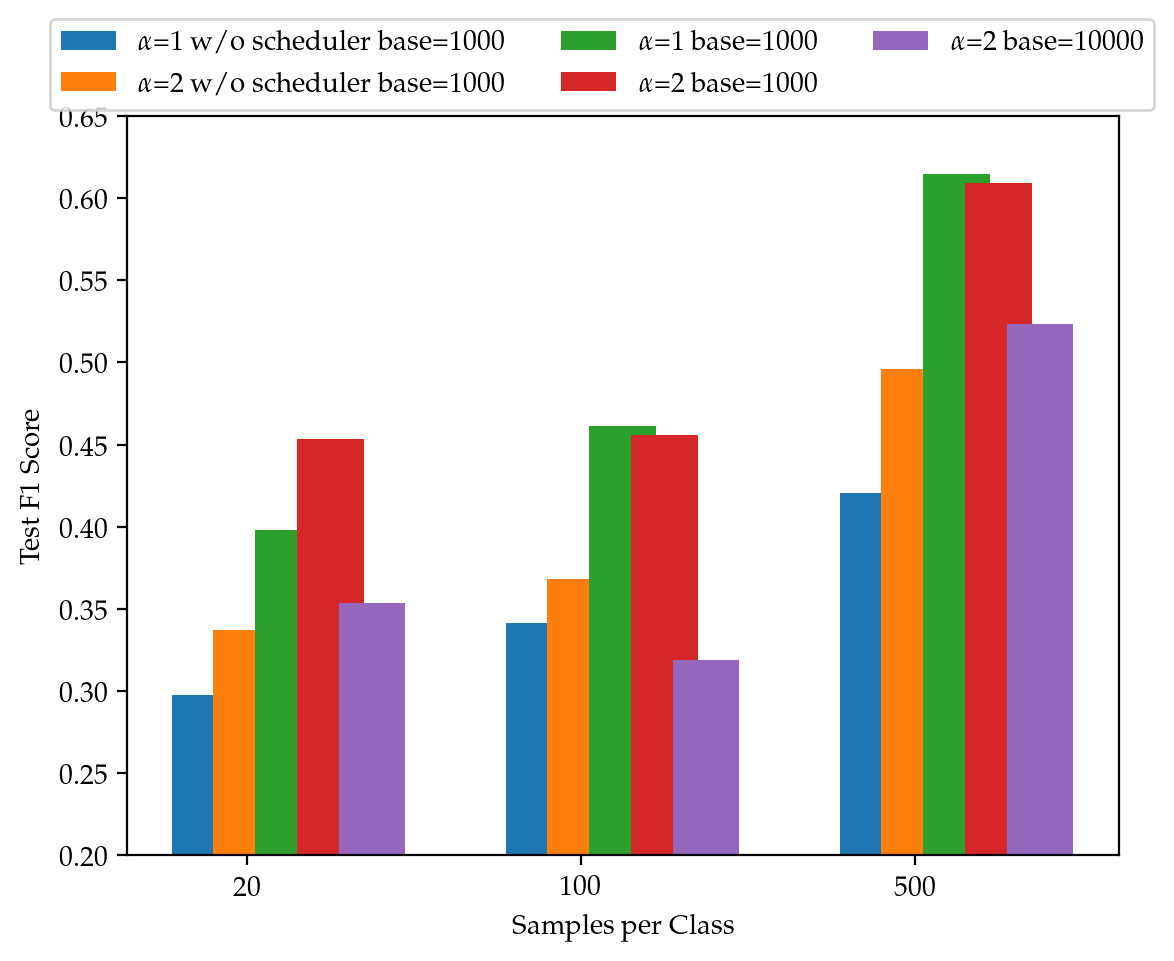

In [205]:
plt.figure(dpi=200)
shift=-0.5
for index, comb in enumerate(results_labels):
    a = results_values[index]
    a = np.array(a)
    x = np.arange(0, 12, 4)
    plt.bar(x+shift, a[:, 0], label=comb)
    plt.xticks(x, partial_labels)
    plt.ylim(0.2, 0.65)
    shift+=0.5
plt.legend(bbox_to_anchor=(1.05, 1.15), ncol=3)
plt.ylabel('Test F1 Score')
plt.xlabel('Samples per Class')